In [1]:
import torch
import torch.nn as nn
import pickle
import numpy as np
from utils import datasets, model_utils, metrics

from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import os, re
from collections import OrderedDict
import copy

In [2]:
def load_model(path, train_dataset, test_dataset):
    checkpoint = torch.load(path)
    state_dict = checkpoint["checkpoint"]
    args = checkpoint["args"]

    if args['block_type'] == "trl3dhalf" and args["bias_rank"] == "full":
        args["bias_rank"] = -1
    print(args)
    
    model = model_utils.get_model(args, train_dataset, test_dataset)
    model.load_state_dict(state_dict)   
    model.eval()
    return model

In [4]:
experiments_name = 'explosion'
train_dataset, test_dataset = datasets.CPDDatasets(experiments_name=experiments_name).get_dataset_()

Equal sampling is impossible, do random sampling.


In [5]:
linear_path = 'saves/models/best_explosion/model_x3d_m_bce_tl_221217T161508.pth'
tcl_path = 'saves/models/best_explosion/model_x3d_m_bce_tl_230123T203200.pth'
trl3dhalf_path = 'saves/models/best_explosion/model_x3d_m_bce_tl_230228T174125.pth'

In [6]:
model_utils.fix_seeds(0)

linear_model = load_model(linear_path, train_dataset, test_dataset)
tcl_model = load_model(tcl_path, train_dataset, test_dataset)
trl3dhalf_model = load_model(trl3dhalf_path, train_dataset, test_dataset)

{'model': 'bce', 'seed': 102, 'experiments_name': 'explosion', 'epochs': 200, 'lr': 0.001, 'dryrun': False, 'bias_rank': 'full', 'block_type': 'linear', 'rnn_type': 'lstm', 'input_block': 'none', 'output_block': 'linear', 'bias': 'all', 'num_layers': 1, 'name': 'x3d_m', 'data_dim': 12288, 'rnn_hid_dim': 64, 'emb_dim': 12288, 'ranks_input': None, 'ranks_rnn': None, 'ranks_output': None, 'batch_size': 16, 'grad_clip': 0.0, 'extractor_params': 2006130, 'model_params': 3162689, 'early_stopping_monitor': 'val_loss', 'early_stopping_patience': 10, 'early_stopping_verbose': True, 'early_stopping_mode': 'min'}
Use extractor x3d_m


Using cache found in /home/cpd/.cache/torch/hub/facebookresearch_pytorchvideo_main


{'model': 'bce', 'seed': 102, 'experiments_name': 'explosion', 'epochs': 200, 'lr': 0.001, 'dryrun': False, 'bias_rank': 2, 'block_type': 'tcl3d', 'rnn_type': 'lstm', 'input_block': 'none', 'output_block': 'linear', 'bias': 'all', 'num_layers': 1, 'name': 'x3d_m', 'data_dim': (192, 8, 8), 'rnn_hid_dim': (16, 16, 16), 'emb_dim': (192, 8, 8), 'ranks_input': None, 'ranks_rnn': None, 'ranks_output': None, 'batch_size': 16, 'grad_clip': 0.0, 'extractor_params': 2006130, 'model_params': 217857, 'early_stopping_monitor': 'val_loss', 'early_stopping_patience': 10, 'early_stopping_verbose': True, 'early_stopping_mode': 'min'}
Use extractor x3d_m
{'model': 'bce', 'seed': 57346, 'experiments_name': 'explosion', 'epochs': 200, 'lr': 0.001, 'dryrun': False, 'bias_rank': -1, 'block_type': 'trl3dhalf', 'rnn_type': 'lstm', 'input_block': 'none', 'output_block': 'linear', 'bias': 'all', 'num_layers': 1, 'name': 'x3d_m', 'data_dim': (192, 8, 8), 'rnn_hid_dim': (32, 8, 8), 'emb_dim': (192, 8, 8), 'ranks_

Using cache found in /home/cpd/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /home/cpd/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [7]:
def get_noised_dataloader(extractor, model_dataloader, mean=0.0, std=1.0):
    noised_data = []
    labels = []

    for data, labels_ in model_dataloader:
        data = extractor(data).transpose(1, 2)
        noised_data.append(data + torch.randn(data.size()) * std + mean)
        labels.append(labels_)

    res = torch.vstack(noised_data), torch.vstack(labels)
    dataset = torch.utils.data.TensorDataset(res[0], res[1])
    noised_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
    
    return noised_dataloader

In [8]:
model_type='trl3dhalf'
model=copy.deepcopy(trl3dhalf_model)

In [9]:
for std in np.linspace(0, 4, 41):
    model_name = model_type + '_with_noise_' + str(round(std, 2))

    threshold_list = np.linspace(-5, 5, 25)
    threshold_list = 1 / (1 + np.exp(-threshold_list))
    threshold_list = [-0.001] + list(threshold_list) + [1.001]

    noised_dataloader = get_noised_dataloader(model.extractor, model.val_dataloader(), mean=0.0, std=std)

    metrics_local, delay_list2d, fp_delay_list2d = metrics.evaluation_pipeline(model.model,
                                                                               noised_dataloader,
                                                                               threshold_list,
                                                                               device='cuda',
                                                                               model_type="seq2seq",
                                                                               verbose=False,
                                                                               scales=["none"])


    path_to_saves = Path('saves/results') / "noise_adding"
    path_to_metric = path_to_saves / "metrics"
    path_to_metric.mkdir(parents=True, exist_ok=True)

    metrics.write_metrics_to_file(f'{str(path_to_metric)}/{model_name}.txt',
                                  metrics_local, None)

In [35]:
path_to_metrics = 'saves/results/noise_adding/metrics/'
tcl_f1s = {}
tcl_aucs = {}

linear_f1s = {}
linear_aucs = {}

trl3dhalf_f1s = {}
trl3dhalf_aucs = {}

for file in os.listdir(path_to_metrics):
    if ".txt" not in file:
        continue
    #std_noise = round(float(re.findall(r'\d+\.\d+|\d+', file)[0]), 2)
    std_noise = round(float(re.findall(r'_\d+\.\d+|_\d+', file)[0][1:]), 2)
    with open(os.path.join(path_to_metrics, file), "rb") as f:
        res = f.readlines()
        if "tcl" in file:     
            tcl_f1s[std_noise] = float(re.findall(rb'[-+]?\b\d+\.\d+\b', res[4])[0])
            tcl_aucs[std_noise] = float(re.findall(rb'[-+]?\b\d+\.\d+\b', res[1])[0])

        if "linear" in file:     
            linear_f1s[std_noise] = float(re.findall(rb'[-+]?\b\d+\.\d+\b', res[4])[0])
            linear_aucs[std_noise] = float(re.findall(rb'[-+]?\b\d+\.\d+\b', res[1])[0])
            
        if "trl3dhalf" in file:    
            trl3dhalf_f1s[std_noise] = float(re.findall(rb'[-+]?\b\d+\.\d+\b', res[4])[0])
            trl3dhalf_aucs[std_noise] = float(re.findall(rb'[-+]?\b\d+\.\d+\b', res[1])[0])
            
            
tcl_f1s = OrderedDict(sorted(tcl_f1s.items(), key=lambda t: t[0]))
tcl_aucs = OrderedDict(sorted(tcl_aucs.items(), key=lambda t: t[0]))

linear_f1s = OrderedDict(sorted(linear_f1s.items(), key=lambda t: t[0]))
linear_aucs = OrderedDict(sorted(linear_aucs.items(), key=lambda t: t[0]))

trl3dhalf_f1s = OrderedDict(sorted(trl3dhalf_f1s.items(), key=lambda t: t[0]))
trl3dhalf_aucs = OrderedDict(sorted(trl3dhalf_aucs.items(), key=lambda t: t[0]))

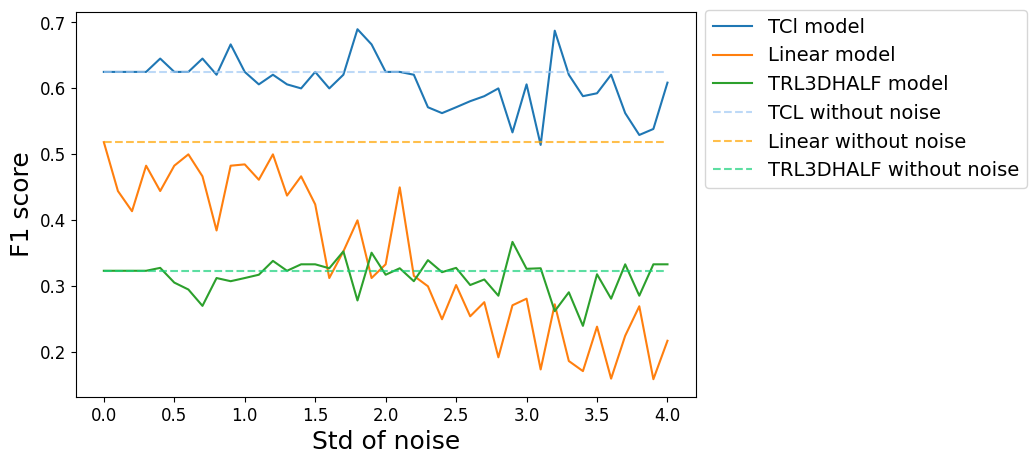

In [37]:
plt.figure(figsize=(8, 5))
plt.plot(tcl_f1s.keys(), tcl_f1s.values(), label='TCl model')
plt.plot(linear_f1s.keys(), linear_f1s.values(), label='Linear model')
plt.plot(trl3dhalf_f1s.keys(), trl3dhalf_f1s.values(), label='TRL3DHALF model')
plt.hlines(tcl_f1s[0], 0, 4, '#a1c9f4', '--', alpha=0.7, label='TCL without noise')
plt.hlines(linear_f1s[0], 0, 4, 'orange', '--', alpha=0.7, label='Linear without noise')
plt.hlines(trl3dhalf_f1s[0], 0, 4, '#18d17b', '--', alpha=0.7, label='TRL3DHALF without noise')
plt.xlabel("Std of noise", fontsize=18)
plt.ylabel("F1 score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, bbox_to_anchor=(1, 1.03))
plt.savefig("noise_f1.png", dpi=500, bbox_inches='tight')

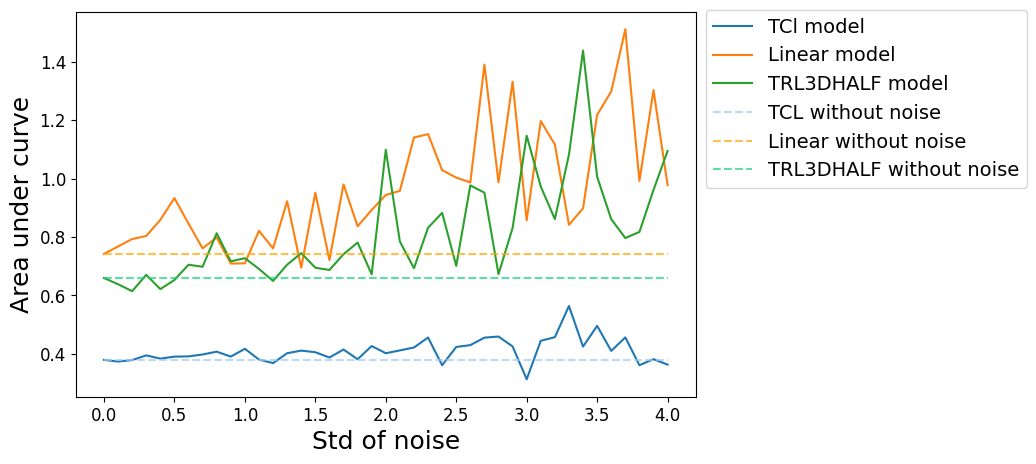

In [39]:
plt.figure(figsize=(8, 5))
plt.plot(tcl_aucs.keys(), tcl_aucs.values(), label='TCl model')
plt.plot(linear_aucs.keys(), linear_aucs.values(), label='Linear model')
plt.plot(trl3dhalf_aucs.keys(), trl3dhalf_aucs.values(), label='TRL3DHALF model')
plt.hlines(tcl_aucs[0], 0, 4, '#a1c9f4', '--', alpha=0.7, label='TCL without noise')
plt.hlines(linear_aucs[0], 0, 4, 'orange', '--', alpha=0.7, label='Linear without noise')
plt.hlines(trl3dhalf_aucs[0], 0, 4, '#18d17b', '--', alpha=0.7, label='TRL3DHALF without noise')
plt.xlabel("Std of noise", fontsize=18)
plt.ylabel("Area under curve", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, bbox_to_anchor=(1, 1.03))
plt.savefig("noise_auc.png", dpi=500, bbox_inches='tight')